<a href="https://colab.research.google.com/github/SamiKhaji/CO-LAB/blob/main/SHL_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khajimahammadsami","key":"c7a84b02e697a7f8ffc6bb35ab085b27"}'}

In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchaudio
import torchaudio.transforms as T


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download -c shl-hiring-assessment
!unzip shl-hiring-assessment.zip -d shl_data


403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/shl-hiring-assessment
unzip:  cannot find or open shl-hiring-assessment.zip, shl-hiring-assessment.zip.zip or shl-hiring-assessment.zip.ZIP.


In [5]:
!kaggle competitions download -c shl-intern-hiring-assessment

In [6]:
!unzip -q shl-intern-hiring-assessment.zip -d shl_data


In [8]:
train_df = pd.read_csv('shl_data/dataset/train.csv')
test_df = pd.read_csv('shl_data/dataset/test.csv')
sample_submission = pd.read_csv('shl_data/dataset/sample_submission.csv')


In [11]:
from tqdm import tqdm

In [110]:
def extract_audio_features(file_path, sr=16000, n_mfcc=40):
    y, _ = librosa.load(file_path, sr=sr)
    features = []

    # 1. MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    features.extend(mfccs_mean)

    # 2. Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)
    features.extend(chroma_mean)

    # 3. Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr.T, axis=0)
    features.append(zcr_mean[0])

    # 4. Spectral Centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(spec_centroid))

    # 5. Spectral Rolloff
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features.append(np.mean(spec_rolloff))

    # 6. RMS Energy
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))

    # 7. Duration
    duration = librosa.get_duration(y=y, sr=sr)
    features.append(duration)

    return np.array(features)


In [111]:
train_features = []
train_labels = []

for fname, label in tqdm(zip(train_df['filename'], train_df['label']), total=len(train_df)):
    file_path = os.path.join("shl_data/dataset/audios_train", fname)
    feat = extract_audio_features(file_path)
    train_features.append(feat)
    train_labels.append(label)

X = np.array(train_features)
y = np.array(train_labels)


100%|██████████| 355/355 [05:45<00:00,  1.03it/s]


In [112]:
print(y[:10])

[3 2 6 6 2 2 7 7 4 8]


In [113]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert y to class indices for classification
label_encoder = LabelEncoder()
y_class = label_encoder.fit_transform(y)

# Now split using y_class
X_train, X_val, y_train, y_val = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Apply standard scaling to features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [114]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [115]:
y_train

array([2, 5, 7, 7, 4, 6, 7, 2, 7, 8, 7, 5, 8, 5, 7, 7, 2, 4, 4, 5, 4, 2,
       8, 7, 3, 4, 4, 3, 4, 3, 2, 2, 6, 8, 2, 4, 7, 6, 5, 8, 2, 7, 6, 2,
       3, 7, 2, 7, 4, 2, 6, 5, 8, 4, 8, 3, 8, 5, 4, 8, 7, 2, 7, 3, 8, 6,
       4, 5, 4, 8, 4, 7, 7, 2, 4, 1, 6, 3, 8, 8, 5, 2, 8, 6, 8, 2, 4, 2,
       4, 8, 8, 7, 4, 6, 8, 2, 2, 6, 4, 7, 2, 4, 5, 2, 7, 3, 3, 7, 4, 5,
       7, 8, 4, 8, 4, 2, 8, 3, 7, 8, 5, 6, 4, 2, 2, 8, 4, 8, 2, 4, 8, 8,
       3, 2, 8, 2, 6, 8, 7, 2, 4, 6, 2, 7, 4, 6, 2, 7, 7, 4, 8, 3, 1, 3,
       5, 7, 7, 6, 7, 6, 4, 2, 8, 6, 3, 8, 3, 7, 4, 4, 3, 7, 2, 5, 8, 2,
       3, 4, 4, 8, 4, 2, 8, 7, 8, 7, 4, 4, 8, 3, 4, 8, 7, 5, 7, 2, 4, 8,
       7, 6, 4, 4, 2, 3, 4, 4, 6, 6, 4, 2, 4, 5, 4, 4, 3, 5, 2, 6, 4, 4,
       6, 8, 4, 8, 8, 2, 8, 8, 2, 8, 2, 8, 5, 3, 3, 8, 2, 8, 8, 2, 8, 4,
       6, 8, 8, 8, 8, 2, 6, 6, 7, 6, 4, 8, 8, 6, 7, 4, 2, 2, 4, 8, 4, 4,
       3, 2, 5, 6, 8, 8, 4, 5, 6, 8, 7, 1, 2, 4, 6, 2, 3, 6, 4, 2])

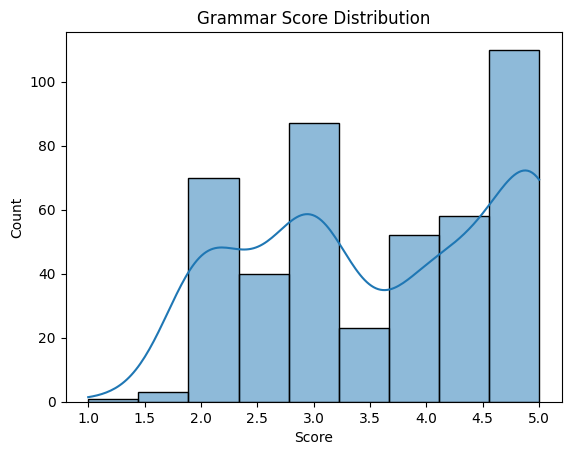

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_df['label'], bins=9, kde=True)
plt.title("Grammar Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()


In [81]:
label_map = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5, 4: 3.0, 5: 3.5, 6: 4.0, 7: 4.5, 8: 5.0, 9: 5.0}


In [120]:
import pandas as pd
import numpy as np

df = pd.read_csv('shl_data/dataset/train.csv')
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(float)

label_map = {
    1.0: 0,
    1.5: 1,
    2.0: 2,
    2.5: 3,
    3.0: 4,
    3.5: 5,
    4.0: 6,
    4.25: 7,
    4.5: 8,
    5.0: 9
}

df['label_id'] = df['label'].map(label_map)

df['filename'] = 'shl_data/dataset/audios_train/' + df['filename']

print(df.head())


                                       filename  label  label_id
0  shl_data/dataset/audios_train/audio_1261.wav    1.0         0
1   shl_data/dataset/audios_train/audio_942.wav    1.5         1
2  shl_data/dataset/audios_train/audio_1110.wav    1.5         1
3  shl_data/dataset/audios_train/audio_1024.wav    1.5         1
4   shl_data/dataset/audios_train/audio_538.wav    2.0         2


In [121]:
print(df['label'])

0      1.0
1      1.5
2      1.5
3      1.5
4      2.0
      ... 
439    5.0
440    5.0
441    5.0
442    5.0
443    5.0
Name: label, Length: 444, dtype: float64


In [122]:
import librosa
import numpy as np
from tqdm import tqdm

def extract_audio_features(file_path, sr=16000, n_mfcc=40):
    y, _ = librosa.load(file_path, sr=sr)
    features = []

    # 1. MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    features.extend(np.mean(mfccs.T, axis=0))

    # 2. Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma.T, axis=0))

    # 3. Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))

    # 4. Spectral Centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(spec_centroid))

    # 5. Spectral Rolloff
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features.append(np.mean(spec_rolloff))

    # 6. RMS Energy
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))

    # 7. Duration
    duration = librosa.get_duration(y=y, sr=sr)
    features.append(duration)

    return np.array(features)

# Apply to the entire dataset
features = []
valid_indices = []

print("Extracting features from audio files...")

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        feats = extract_audio_features(row['filename'])
        features.append(feats)
        valid_indices.append(i)
    except Exception as e:
        print(f"Error with file {row['filename']}: {e}")

df = df.loc[valid_indices].reset_index(drop=True)
X = np.array(features)
y = df['label'].values


Extracting features from audio files...


100%|██████████| 444/444 [06:01<00:00,  1.23it/s]


In [123]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_dup = X.tolist()
y_dup = y_encoded.tolist()

counter = Counter(y_dup)
for label, count in counter.items():
    if count < 2:
        idx = y_dup.index(label)
        X_dup.append(X_dup[idx])
        y_dup.append(label)

X_dup = np.array(X_dup)
y_dup = np.array(y_dup)

X_train, X_val, y_train, y_val = train_test_split(
    X_dup, y_dup,
    test_size=0.2,
    random_state=42,
    stratify=y_dup
)

print("✅ Train and validation split done.")


✅ Train and validation split done.


In [124]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

from collections import Counter
print("✅ SMOTE applied.")
print("🔢 Class distribution after SMOTE:", Counter(y_train_sm))


✅ SMOTE applied.
🔢 Class distribution after SMOTE: Counter({np.int64(7): 88, np.int64(6): 88, np.int64(4): 88, np.int64(3): 88, np.int64(8): 88, np.int64(2): 88, np.int64(0): 88, np.int64(5): 88, np.int64(1): 88})


In [125]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6
)
model.fit(X_train_sm, y_train_sm)
y_pred = model.predict(X_val)
print("📊 Validation Accuracy:", accuracy_score(y_val, y_pred) * 100, "%")
print("\n📋 Classification Report:\n", classification_report(y_val, y_pred))


📊 Validation Accuracy: 38.20224719101123 %

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.36      0.29      0.32        14
           3       0.33      0.25      0.29         8
           4       0.45      0.53      0.49        17
           5       0.00      0.00      0.00         5
           6       0.33      0.20      0.25        10
           7       0.29      0.50      0.36        12
           8       0.65      0.50      0.56        22

    accuracy                           0.38        89
   macro avg       0.27      0.25      0.25        89
weighted avg       0.41      0.38      0.39        89



In [130]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder


audio_test_dir = "shl_data/dataset/audios_test"
test_df = pd.read_csv("shl_data/dataset/test.csv")
le = LabelEncoder()
le.classes_ = np.array(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'])

def extract_mfcc(path, max_len=40):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.flatten()

X_test = []
test_files = []

print("🔍 Extracting features from test audio...")
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(audio_test_dir, row["filename"])
    try:
        feats = extract_audio_features(file_path)
        X_test.append(feats)
        test_files.append(row["filename"])
    except Exception as e:
        print(f"⚠️ Error processing {row['filename']}: {e}")

X_test = np.array(X_test)
le = LabelEncoder()
le.classes_ = np.array(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'])
y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
submission = pd.DataFrame({
    "filename": test_files,
    "label": y_pred_labels
})

submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved as submission.csv")


🔍 Extracting features from test audio...


100%|██████████| 195/195 [03:41<00:00,  1.13s/it]

✅ Submission file saved as submission.csv
